In [1]:
print("NSMC Data Sentiment Analysis Base On CNN")

NSMC Data Sentiment Analysis Base On CNN


In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minkikwak","key":"8bbf6c259863c84c9ce8ada021aa02a6"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s "Naver Movie Review DataSet"

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
ehddnr301/naver-review                                    naver review                                         8MB  2020-09-28 07:59:30              2  
yusian112/vlive                                           Naver Vlive videos dataset                           7MB  2018-06-06 13:26:54            226  
soohyun/naver-movie-review-dataset                        Naver Movie Review Dataset                           8MB  2020-07-28 07:33:04             10  
wysohn2/naver-blog-results                                naver_blog_results                                  65MB  2020-08-01 22:46:37              0  
inheelee2/naver33                                         naver33                 

In [5]:
!kaggle datasets download -d soohyun/naver-movie-review-dataset

  0% 0.00/8.26M [00:00<?, ?B/s]
100% 8.26M/8.26M [00:00<00:00, 76.1MB/s]


In [6]:
!unzip naver-movie-review-dataset.zip
!ls -ltr

Archive:  naver-movie-review-dataset.zip
  inflating: ratings_test.txt        
  inflating: ratings_train.txt       
total 27536
-rw-r--r-- 1 root root  4893335 Jul 28 07:33 ratings_test.txt
-rw-r--r-- 1 root root 14628807 Jul 28 07:33 ratings_train.txt
drwxr-xr-x 1 root root     4096 Dec 21 17:29 sample_data
-rw-r--r-- 1 root root       65 Dec 24 19:02 kaggle.json
-rw-r--r-- 1 root root  8661396 Dec 24 19:03 naver-movie-review-dataset.zip


In [8]:
!git clone https://github.com/e9t/nsmc.git
!cp /content/nsmc/rating* /content

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 20.38 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [7]:
pip install konlpy

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 460kB 43.3MB/s 
     |████████████████████████████████| 92kB 9.9MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [9]:
from konlpy.tag import Okt
import re
import os
import pandas as pd
import numpy as np
import nltk
import random
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')

#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
#불용어 정의 및 토크나이저 객체 선언
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '을', '께서']
okt = Okt()

#특수문자 패턴 정의
pattern1 = '[^\w\s]'          # 특수기호제거
pattern2 = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
pattern3 = '[a-zA-z]'

def readData(dataset_type):
  max_seq_len = 0
  with open("./%s.txt" % dataset_type, "r", encoding="utf-8") as fr_handle:
    labels, reviews = [], []
    for line in fr_handle:
      if line.strip() == 0:
        continue
      elif line.split()[0] == "id":
        continue
      label = int(line.split()[-1])

      document = ' '.join(line.split()[1:-1])
      symbol_deleted = re.sub(pattern=pattern1, repl='', string=document)               #특수문자 제거
      symbol_deleted = re.sub(pattern=pattern2, repl='', string=symbol_deleted)         #한글 자/모음 제거
      symbol_deleted = re.sub(pattern=pattern3, repl='', string=symbol_deleted)         #영어 알파벳 제거
      #symbol_deleted = document.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
      tokenized = okt.morphs(symbol_deleted, stem=True)                                 #토큰화
      review = [token for token in tokenized if not token in stopwords]                 #불용어 제거
      max_seq_len = max(max_seq_len, len(review))                                       #가장 긴 문장길이 구하기 for Padding
      #tokenized_review = nltk.word_tokenize(review) #단어 단위 분리
      labels.append(label)
      reviews.append(review)
    reviews, labels = delNulls(reviews, labels)
  return labels, reviews, max_seq_len

#Null Data 제거
def delNulls(list1, list2):
  newList1, newList2 = [], []
  for i in range(0, len(list1), 1):
    if len(list1[i]) != 0:
      newList1.append(list1[i])
      newList2.append(list2[i])
  return newList1, newList2

#출력 함수
def printList(myList):
  for i in range(0, 10, 1):
    print(myList[i])
  print("")

myTrainLabel, myTrainSet, myTrainMaxLen = readData("ratings_train") #학습데이터 읽기
myTestLabel, myTestSet, myTestMaxLen = readData("ratings_test") #테스트데이터 읽기
max_len = max(myTrainMaxLen, myTestMaxLen) #Train과 Test 전체에서 가장 긴 길이

print(len(myTrainSet))
print(len(myTrainLabel))

print(len(myTestSet))
print(len(myTestLabel))

printList(myTrainSet)
printList(myTrainLabel)
printList(myTestSet)
printList(myTestLabel)

#print("Train : ", len(myTrainSet))
#for kor_train_label, kor_train_sent in zip(myTrainLabel, myTrainSet[0:20]):
#  print(kor_train_label, ':' ,kor_train_sent)

#print()
#print("Test : ", len(myTestSet))
#for kor_test_label, kor_test_sent in zip(myTestLabel, myTestSet[0:20]):
#  print(kor_test_label, ':' ,kor_test_sent)

148542
148542
49487
49487
['아', '더빙', '진짜', '짜증나다', '목소리']
['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']
['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']
['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정']
['사이', '몬페', '그', '익살스럽다', '연기', '돋보이다', '영화', '스파이더맨', '에서', '늙다', '보이다', '커스틴', '던스트', '너무나도', '이쁘다', '보이다']
['막', '걸음', '마', '떼다', '3', '세', '부터', '초등학교', '1', '학년', '생인', '8', '살다', '영화', '별', '반개', '아깝다', '움']
['원작', '긴장감', '제대로', '살리다']
['별', '반개', '아깝다', '욕', '나오다', '이응경', '길용우', '연', '기', '생활', '몇', '년', '인지', '정말', '발', '로', '해도', '그것', '보단', '낫다', '납치', '감금', '만', '반복', '반복', '드라마', '가족', '없다', '연기', '못', '사람', '만', '모', '엿', '네']
['액션', '없다', '재미', '있다', '몇', '안되다', '영화']
['왜케', '평점', '낮다', '꽤', '볼', '만', '데', '헐리우드', '식', '화려하다', '너무', '길들이다', '있다']

0
1
0
0
1
0
0
0
1
1

['굳다']
['뭐', '야', '평점', '나쁘다', '않다', '10', '점', '짜다', '리', '더', '더욱', '아니다']
['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']
['3만', '아니다', '별', '다섯', '개', '주다', '왜', '3', '로', '

In [33]:
#여기서부터 Padding Size(=max_len) 를 바꿔가며 실험 수행

#데이터 로드 및 파싱 과정이 오래 소요 되어 Call-By-Value 원리 사용
TrainSet = myTrainSet
TestSet = myTestSet

tokenizer = Tokenizer()
tokenizer.fit_on_texts(TrainSet)

#vocab_size 계산
print(tokenizer.word_index)
vocab_size = len(tokenizer.word_index)
print(vocab_size)

tokenizer = Tokenizer(20000)
#tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(TrainSet)

#Review Data를 Sequence Data로 Converting
TrainSet = tokenizer.texts_to_sequences(TrainSet)
TestSet = tokenizer.texts_to_sequences(TestSet)

#Label 값 파싱
#TrainLabel = np.array(myTrainLabel)
#TestLabel = np.array(myTestLabel)

from keras.utils import np_utils

#One-Hot 인코딩
TrainLabel = np_utils.to_categorical(myTrainLabel)
TestLabel = np_utils.to_categorical(myTestLabel)

print(TrainSet[:10])
print(TestSet[:10])
print(TrainLabel)
print(TestLabel)

{'영화': 1, '보다': 2, '없다': 3, '이다': 4, '있다': 5, '좋다': 6, '너무': 7, '다': 8, '정말': 9, '재밌다': 10, '되다': 11, '적': 12, '만': 13, '같다': 14, '진짜': 15, '점': 16, '로': 17, '아니다': 18, '않다': 19, '에서': 20, '만들다': 21, '나오다': 22, '연기': 23, '평점': 24, '것': 25, '최고': 26, '내': 27, '그': 28, '나': 29, '인': 30, '안': 31, '스토리': 32, '생각': 33, '못': 34, '왜': 35, '드라마': 36, '게': 37, '감동': 38, '사람': 39, '보고': 40, '1': 41, '이렇다': 42, '말': 43, '아깝다': 44, '고': 45, '더': 46, '때': 47, '배우': 48, '재미있다': 49, '아': 50, '감독': 51, '거': 52, '그냥': 53, '요': 54, '재미': 55, '중': 56, '내용': 57, '뭐': 58, '까지': 59, '주다': 60, '재미없다': 61, '자다': 62, '하고': 63, '지루하다': 64, '쓰레기': 65, '네': 66, '시간': 67, '수': 68, '가다': 69, '모르다': 70, '들다': 71, '그렇다': 72, '싶다': 73, '지': 74, '10': 75, '작품': 76, '사랑': 77, '알다': 78, '하나': 79, '다시': 80, '볼': 81, '마지막': 82, '이건': 83, '저': 84, '정도': 85, '완전': 86, '오다': 87, '많다': 88, '처음': 89, '장면': 90, '액션': 91, '주인공': 92, '2': 93, '이렇게': 94, '걸': 95, '안되다': 96, '차다': 97, '개': 98, '최악': 99, '나다': 100, '하': 101, '돈': 102

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.41154017045684


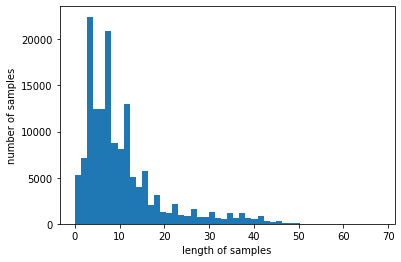

> Length가 30 이하인 데이터의 비율 : 94.66750144740207
> Length가 40 이하인 데이터의 비율 : 98.6569455103607
> Length가 50 이하인 데이터의 비율 : 99.95758775295876
> Length가 60 이하인 데이터의 비율 : 99.99730715891802
> Length가 70 이하인 데이터의 비율 : 100.0


In [34]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(l) for l in TrainSet))
print('리뷰의 평균 길이 :',sum(map(len, TrainSet))/len(TrainSet))
plt.hist([len(s) for s in TrainSet], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def calculateRatio(max_len, dataset):
  count = 0
  for data in dataset:
    if(len(data) <= max_len):
        count = count + 1
  print('> Length가', max_len, '이하인 데이터의 비율 : %s' % (count / len(dataset)*100))

calculateRatio(30, TrainSet)
calculateRatio(40, TrainSet)
calculateRatio(50, TrainSet)
calculateRatio(60, TrainSet)
calculateRatio(70, TrainSet)

max_len = 40                    #Padding Size

In [35]:
TrainSet = pad_sequences(TrainSet, padding='post', maxlen = max_len)
TestSet = pad_sequences(TestSet, padding='post', maxlen = max_len)

print("현재 Padding Size는", max_len, "입니다")
print(TrainSet[:2])
print(TestSet[:2])

현재 Padding Size는 40 입니다
[[  50  450   15  252  656    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [ 913  452   40  596    1  210 1451   23  962  670   19    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[641   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 58 159  24 425  19  75  16 311 897  46 776  18   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


In [36]:
### 랜덤 임베딩 방식

#라이브러리 호출
from keras.models import Sequential
from keras import layers
from keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, MaxPooling1D, Conv1D, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import timeit
import matplotlib.pyplot as plt

#변수 선언/초기화
max_len = 40                    #Padding Size
embedding_dimension = 30
batch_size = 256
filter_count = 256
filters = [2, 3, 4]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

#모델 객체 선언
model = Sequential()

#모델 구성
#model.add(Embedding(vocab_size, embedding_dimension, input_length=max_len))
model.add(Embedding(20000, embedding_dimension, input_length=max_len))
model.add(Conv1D(filters=filter_count, kernel_size=filters[0], activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_count, kernel_size=filters[1], activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filter_count, kernel_size=filters[2], activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

print("> 현재 Padding Size는 ", max_len, "입니다")
print("> 현재 Embedding Dimension은 ", embedding_dimension, "입니다")
#print("> 현재 Filter 정보 : (Size 2) x (필터 128개) x (Layer 3개)")

#모델 정보 출력
model.summary()

#모델 컴파일
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

#시작 시간 체크
startTime = timeit.default_timer()

#모델 평가
test_loss, test_accuracy = model.evaluate(TestSet, TestLabel)
print("Test_Accuracy : ", test_accuracy)

#모델 훈련
history = model.fit(TrainSet, TrainLabel, epochs=10, verbose=True, callbacks=[es, mc], batch_size=batch_size, validation_split=0.1)
#history = model.fit(TrainSet, TrainLabel, epochs=10, verbose=True, batch_size=batch_size, validation_split=0.2)

#시간 체크
endTime = timeit.default_timer()
print("시작시간 : ", startTime)
print("종료시간 : ", endTime)
print("소요시간 : ", endTime-startTime)

#모델 평가
test_loss, test_accuracy = model.evaluate(TestSet, TestLabel)
print("Test_Accuracy : ", test_accuracy)

#print("> 현재 Filter의 갯수는 ", len(filters)*filter_count, "입니다")
#print("> 현재 Filter의 크기는 ", filter_size, "입니다")

> 현재 Padding Size는  40 입니다
> 현재 Embedding Dimension은  30 입니다
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 30)            600000    
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 39, 256)           15616     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 19, 256)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 17, 256)           196864    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 8, 256)            0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5, 256)            262400    
__________________________________________________________

In [37]:
#https://hansonminlearning.tistory.com/12

#모델 저장
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)
    
#가중치 저장
model.save_weights("model_weight.h5")
print("모델 저장 완료")

모델 저장 완료


In [38]:
#https://hansonminlearning.tistory.com/12

#모델 로드
from keras.models import model_from_json 
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)
 
#가중치 로드
model.load_weights("model_weight.h5")
print("모델 로딩 완료")

#모델 평가
test_loss, test_accuracy = model.evaluate(TestSet, TestLabel)
print("Test_Accuracy : ", test_accuracy)

모델 로딩 완료
1547/1547 [==============================] - 15s 10ms/step - loss: 0.5724 - accuracy: 0.8334
Test_Accuracy :  0.8333905935287476


In [45]:
#Kaggle에서 테스트 데이터 다운로드
!kaggle competitions download -c korean-sa-competition-bdc101

  0% 0.00/608k [00:00<?, ?B/s]
100% 608k/608k [00:00<00:00, 41.3MB/s]


In [49]:
#라이브러리 호출
import pandas as pd
import numpy as np
from konlpy.tag import Okt
import re
import csv

#변수 선언
sentences = []
idx = []

#불용어 제거 및 토크나이징
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '을', '께서']
okt = Okt()

#특수문자 패턴 정의
pattern1 = '[^\w\s]'          # 특수기호제거
pattern2 = '([ㄱ-ㅎㅏ-ㅣ]+)'  # 한글 자음, 모음 제거
pattern3 = '[a-zA-z]'

def readCSV():
  with open("./ko_data.csv", "r", encoding="cp949") as raw_file:
    reader = csv.reader(raw_file)
    for line in reader:
      if line[0] == "Id":
        continue
      csv_document = line[1]
      csv_symbol_deleted = re.sub(pattern=pattern1, repl='', string=csv_document)               #특수문자 제거
      csv_symbol_deleted = re.sub(pattern=pattern2, repl='', string=csv_symbol_deleted)         #한글 자/모음 제거
      csv_symbol_deleted = re.sub(pattern=pattern3, repl='', string=csv_symbol_deleted)         #영어 알파벳 제거
      csv_tokenized = okt.morphs(csv_symbol_deleted, stem=True)                                 #토큰화
      sentence = [token for token in csv_tokenized if not token in stopwords]                   #불용어 제거
      sentences.append(sentence)
      idx.append(line[0])
  return sentences, idx

PredictSet, PredictId = readCSV()                          #학습데이터 읽기

#출력 함수
def printList(myList):
  for i in range(0, 10, 1):
    print(myList[i])
  print("")

print(len(PredictSet))
print(PredictSet)
print(PredictId)

11187
[['정말', '많이', '울다', '영화', '이다'], ['시간', '낭비', '예요'], ['포스터', '저렇게', '밖에', '만들다', '못', '제작자', '소심하다', '침', '뱉다', '싶다'], ['지금', '보다', '재미있다', '영화', '코믹', '감동', '그리고', '요리'], ['걸', '영화로', '만들다', '거', '야', '얼마나', '가다', '보다'], ['잔잔하다', '감동', '주다', '영화', '좋다', '영화', '다', '줄리', '안', '무어', '매력'], ['프랑스', '영화', '정말', '재미없다', '말', '밖에'], ['이보', '다', '더', '자연스럽다', '수', '없다'], ['잠', '만', '자고', '있다'], ['오프닝', '씬', '영화', '젊음', '대해', '말'], ['내용', '재미있다', '유덕화', '가장', '멋지다', '나오다', '영화'], ['영화', '없다', '색깔', '만', '있다'], ['홍성', '진', '영화', '해설', '님', '우뢰매', '욕'], ['게', '뭐라다'], ['우울하다', '작가', '주의', '인', '척'], ['재밌다'], ['최고', '녹화', '찍다', '걸', '볼', '수', '있다', '정말', '다행', '이야'], ['보다', '동감', '많이', '해', '요', '보다', '남', '일이', '아니다', '것', '같다', '수고'], ['역시', '강', '씨'], ['오오', '정말', '좋아하다'], ['진', '저', '얼굴', '짱', '몸짱', '정말', '이쁘다'], ['감동', '함께', '감성', '자극', '줍다'], ['힘', '강렬하다', '정말로', '산뜻하다', '영화', '다'], ['우리', '은별', '언니'], ['분위기', '만', '나쁘다', '끝나다'], ['소설', '보다', '듯', '지루하다', '줄거리', '볼썽', '사납다', '액션'], ['

In [55]:
myPredictSet = PredictSet

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(myPredictSet)

print(tokenizer2.word_index)
vocab_size2 = len(tokenizer2.word_index)
print(vocab_size2)

{'영화': 1, '보다': 2, '것': 3, '없다': 4, '있다': 5, '이다': 6, '정말': 7, '좋다': 8, '너무': 9, '재미있다': 10, '같다': 11, '않다': 12, '적': 13, '다': 14, '점': 15, '재밌다': 16, '최고': 17, '만': 18, '되다': 19, '수': 20, '에서': 21, '아니다': 22, '로': 23, '평점': 24, '이렇다': 25, '왜': 26, '연기': 27, '감동': 28, '나': 29, '나오다': 30, '만들다': 31, '보고': 32, '재미없다': 33, '인': 34, '내': 35, '진짜': 36, '게': 37, '안': 38, '드라마': 39, '말': 40, '때': 41, '거': 42, '생각': 43, '싶다': 44, '아깝다': 45, '못': 46, '야': 47, '스토리': 48, '그': 49, '사람': 50, '아': 51, '1': 52, '더': 53, '쓰레기': 54, '내용': 55, '배우': 56, '감독': 57, '지루하다': 58, '까지': 59, '자다': 60, '시간': 61, '뭐': 62, '주다': 63, '볼': 64, '중': 65, '그냥': 66, '모르다': 67, '네': 68, '액션': 69, '재미': 70, '좋아하다': 71, '요': 72, '그렇다': 73, '작품': 74, '별로': 75, '하고': 76, '처음': 77, '이렇게': 78, '10': 79, '마지막': 80, '정도': 81, '고': 82, '하나': 83, '가다': 84, '알다': 85, '다시': 86, '이야기': 87, '지금': 88, '이야': 89, '최악': 90, '장면': 91, '사랑': 92, '저': 93, '인데': 94, '한국': 95, '오다': 96, '들다': 97, '주인공': 98, '라고': 99, '줄': 100, '많다': 101, '역시

In [56]:
print(myPredictSet)
myPredictSet = tokenizer2.texts_to_sequences(myPredictSet)
print(myPredictSet)

max_len = 40
myPredictSet = pad_sequences(myPredictSet, padding='post', maxlen = max_len)
print(myPredictSet)

#PredictID = np.array(predict_data['Id'])

print(len(myPredictSet))
print(len(PredictId))

[['정말', '많이', '울다', '영화', '이다'], ['시간', '낭비', '예요'], ['포스터', '저렇게', '밖에', '만들다', '못', '제작자', '소심하다', '침', '뱉다', '싶다'], ['지금', '보다', '재미있다', '영화', '코믹', '감동', '그리고', '요리'], ['걸', '영화로', '만들다', '거', '야', '얼마나', '가다', '보다'], ['잔잔하다', '감동', '주다', '영화', '좋다', '영화', '다', '줄리', '안', '무어', '매력'], ['프랑스', '영화', '정말', '재미없다', '말', '밖에'], ['이보', '다', '더', '자연스럽다', '수', '없다'], ['잠', '만', '자고', '있다'], ['오프닝', '씬', '영화', '젊음', '대해', '말'], ['내용', '재미있다', '유덕화', '가장', '멋지다', '나오다', '영화'], ['영화', '없다', '색깔', '만', '있다'], ['홍성', '진', '영화', '해설', '님', '우뢰매', '욕'], ['게', '뭐라다'], ['우울하다', '작가', '주의', '인', '척'], ['재밌다'], ['최고', '녹화', '찍다', '걸', '볼', '수', '있다', '정말', '다행', '이야'], ['보다', '동감', '많이', '해', '요', '보다', '남', '일이', '아니다', '것', '같다', '수고'], ['역시', '강', '씨'], ['오오', '정말', '좋아하다'], ['진', '저', '얼굴', '짱', '몸짱', '정말', '이쁘다'], ['감동', '함께', '감성', '자극', '줍다'], ['힘', '강렬하다', '정말로', '산뜻하다', '영화', '다'], ['우리', '은별', '언니'], ['분위기', '만', '나쁘다', '끝나다'], ['소설', '보다', '듯', '지루하다', '줄거리', '볼썽', '사납다', '액션'], ['충훈이', 

In [57]:
predicted_result = model.predict(myPredictSet)
print(predicted_result)

PredictLabel = np.argmax(predicted_result, axis=1)
print(PredictLabel)

[[1.6544975e-01 8.3455026e-01]
 [1.5658818e-01 8.4341186e-01]
 [4.3507791e-03 9.9564928e-01]
 ...
 [9.9999058e-01 9.4159041e-06]
 [7.8411704e-01 2.1588291e-01]
 [2.5954440e-01 7.4045557e-01]]
[1 1 1 ... 0 0 1]


In [61]:
submit_file = open("sample.csv", "w", encoding='UTF-8')
df = pd.DataFrame({'Id':PredictId, 'Predicted':PredictLabel})
df.to_csv("sample.csv", mode="w", index=False)

!kaggle competitions submit -c korean-sa-competition-bdc101 -f sample.csv -m "1차 제출"

100% 76.6k/76.6k [00:00<00:00, 296kB/s]
Successfully submitted to Korean SA Competition - BDC101